In [8]:
import numpy as np
import os
import json

In [5]:
path = "/src/src/out_vit_c100_fold0/corruptions_top1/weights_location/exp-c100c-fl-2_location_n24_weight_bl.npy"
pos_bef, pos_aft = np.load(path, allow_pickle=True)
print(pos_bef.shape, pos_aft.shape)
print(pos_bef.shape[0] + pos_aft.shape[0])

(1958, 2) (2650, 2)
4608


In [7]:
path = "/src/src/out_vit_c100_fold0/corruptions_top1/weights_location/exp-c100c-fl-1_location_n0.03_w4608_weight.npy"
pos_bef, pos_aft = np.load(path, allow_pickle=True)
print(pos_bef.shape, pos_aft.shape)
print(pos_bef.shape[0] + pos_aft.shape[0])

(1767, 2) (2841, 2)
4608


In [9]:
path = "/src/src/out_vit_c100_fold0/cache_hidden_states_before_layernorm_repair/hidden_states_before_layernorm_11.npy"
cache_states = np.load(path, mmap_mode='r')
print(cache_states.shape)

(10000, 197, 768)


In [11]:
path = "/src/src/out_vit_c100_fold0/cache_hidden_states_before_layernorm_shot_noise/hidden_states_before_layernorm_11.npy"
cache_states = np.load(path, mmap_mode='r')
print(cache_states.shape)

(50000, 197, 768)


In [16]:
from utils.vit_util import transforms_c100, get_batched_hs, get_batched_labels, ViTFromLastLayer, get_ori_model_predictions
from utils.constant import ViTExperiment
from utils.helper import get_device
from transformers import ViTForImageClassification
from tqdm.notebook import tqdm
import torch
import os
import numpy as np
from datasets import load_from_disk
tgt_pos = ViTExperiment.CLS_IDX

In [ ]:
pretrained_dir = ViTExperiment.c100.OUTPUT_DIR.format(k=0)
device = get_device()
# pretrained modelのロード
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
vit_from_last_layer = ViTFromLastLayer(model)
vit_from_last_layer.eval()

Device: cuda


ViTFromLastLayer(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (i

In [4]:
cache_path = "/src/src/out_vit_c100_fold0/cache_hidden_states_before_layernorm_repair/hidden_states_before_layernorm_11.npy"
clean_hs = get_batched_hs(cache_path, batch_size=ViTExperiment.BATCH_SIZE)

/src/src/utils/vit_util.py:640: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  hs_before_layernorm = torch.from_numpy(np.load(hs_save_path, mmap_mode="r")).to(device)


In [13]:
all_logits = []
all_proba = []
all_pred_labels = []
for cached_state in tqdm(clean_hs, total=len(clean_hs)):
    # ここでViTFromLastLayerのforwardが実行される
    logits = vit_from_last_layer(hidden_states_before_layernorm=cached_state, tgt_pos=tgt_pos)
    proba = torch.nn.functional.softmax(logits, dim=-1)
    logits = logits.detach().cpu().numpy()
    proba = proba.detach().cpu().numpy()
    all_logits.append(logits)
    all_proba.append(proba)
all_logits = np.concatenate(all_logits, axis=0)
all_proba = np.concatenate(all_proba, axis=0)
all_pred_labels = all_logits.argmax(axis=-1)
print(f"all_logits.shape: {all_logits.shape}, all_proba.shape: {all_proba.shape}, all_pred_labels.shape: {all_pred_labels.shape}")

  0%|          | 0/313 [00:00<?, ?it/s]

all_logits.shape: (10000, 100), all_proba.shape: (10000, 100), all_pred_labels.shape: (10000,)


In [36]:
# datasetをロード (true_labelsが欲しいので)
ds_name, k = "c100", 0
ds_dirname = f"{ds_name}_fold{k}"
tgt_split = "repair"
ds = load_from_disk(os.path.join(ViTExperiment.DATASET_DIR, ds_dirname))
label_col = "fine_label"
true_labels = np.array(ds[tgt_split][label_col])
# true_labelsとall_pred_labelsを比較して正解率を算出
is_correct = np.equal(true_labels, all_pred_labels)
is_correct = is_correct.astype(np.int32)
total_correct = np.sum(is_correct)
total = len(true_labels)
accuracy = total_correct / total
print(f"accuracy: {accuracy:.4f} ({total_correct}/{total})")

accuracy: 0.9074 (9074/10000)


In [67]:
# 正解時と不正解時の正解ラベルへの予測確率分布を出す
correct_proba = all_proba[is_correct == 1]
incorrect_proba = all_proba[is_correct == 0]
labels_when_correct = true_labels[is_correct == 1]
labels_when_incorrect = true_labels[is_correct == 0]
correct_confidences = correct_proba[np.arange(len(correct_proba)), labels_when_correct]
incorrect_confidences = incorrect_proba[np.arange(len(incorrect_proba)), labels_when_incorrect]

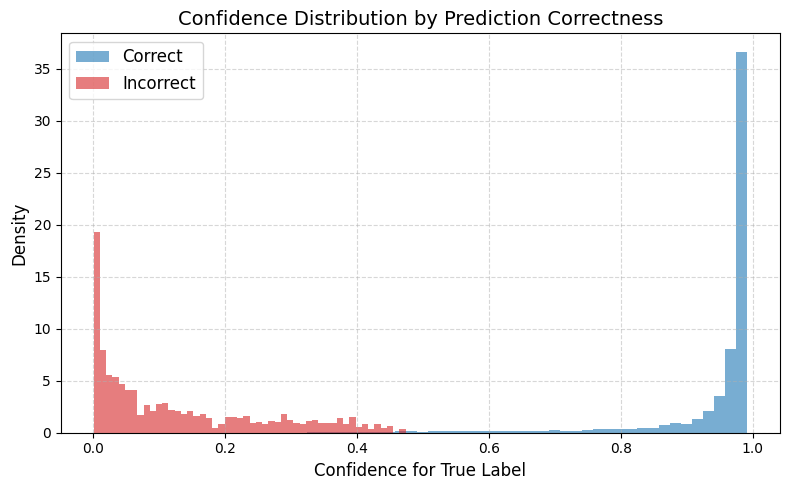

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Notebook向け
%matplotlib inline  

plt.figure(figsize=(8, 5))

plt.hist(correct_confidences, bins=50, alpha=0.6, label='Correct', color='tab:blue', density=True)
plt.hist(incorrect_confidences, bins=50, alpha=0.6, label='Incorrect', color='tab:red', density=True)

plt.xlabel('Confidence for True Label', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Confidence Distribution by Prediction Correctness', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


正解時と不正解時で正解ラベルへの予測確率（confidence for true label）は全然違う．なのでこれらは分けてFLの評価をすべき！